<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 11: Análisis de Componentes Principales (PCA), Introducción</span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

# Introducción al Análisis de Componentes Principales (PCA)

El **Análisis de Componentes Principales (PCA, por sus siglas en inglés)** es una técnica estadística y matemática utilizada para reducir la dimensionalidad de un conjunto de datos, manteniendo la mayor cantidad posible de la variabilidad original. Su propósito principal es transformar un conjunto de variables posiblemente correlacionadas en un nuevo conjunto de variables no correlacionadas, llamadas **componentes principales**.

Cada componente principal es una combinación lineal de las variables originales y está ordenada de forma que el primer componente explica la mayor parte de la varianza de los datos, el segundo explica la mayor parte de la varianza restante, y así sucesivamente. Esto permite representar la información de un conjunto de datos multidimensional en un espacio de menor dimensión, facilitando tanto la **visualización** como la **interpretación** de las estructuras internas de los datos.

En este notebook realizaremos el procedimiento del PCA de forma **manual**, utilizando únicamente operaciones básicas de álgebra lineal con **NumPy**, para comprender en detalle cada paso del método. Trabajaremos con el clásico conjunto de datos **Iris**, que contiene medidas de distintas características de flores de tres especies diferentes. Este dataset es ideal para ilustrar cómo el PCA puede identificar las direcciones de mayor variación y ayudar a distinguir patrones entre clases.

El flujo general de este análisis será el siguiente:

1. **Estandarización de los datos**: ajustar las variables para que tengan media cero y varianza unitaria.  
2. **Cálculo de la matriz de covarianza**: representar las relaciones lineales entre las variables.  
3. **Obtención de valores y vectores propios**: determinar las direcciones (componentes) de mayor varianza.  
4. **Selección de componentes principales**: elegir las más relevantes para la representación de los datos.  
5. **Proyección de los datos**: transformar el conjunto original al nuevo espacio de componentes principales.

De esta manera, podremos entender no solo los resultados del PCA, sino también la lógica matemática que lo fundamenta.

In [41]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

## Importación de datos

In [5]:
# Importación de datos
iris = load_iris()

df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target
df_iris['species'] = df_iris['species'].map(dict(zip(range(3), iris.target_names)))

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
data_iris[data_iris['Species'] == 'setosa'].shape

(50, 5)

## Descripción del conjunto de datos *Iris*

El conjunto de datos **Iris** es uno de los más conocidos y utilizados en el aprendizaje automático. Consta de **150 muestras de flores** del género *Iris*, clasificadas en **tres especies**:

- *Iris setosa*  
- *Iris versicolor*  
- *Iris virginica*  

Cada especie está representada por **50 observaciones**. Una de las clases (*Iris setosa*) es **linealmente separable** de las otras dos, lo que lo convierte en un conjunto ideal para experimentar con algoritmos de clasificación y reducción de dimensionalidad.

Las variables medidas corresponden a las dimensiones de los sépalos y pétalos de cada flor:

| Variable | Descripción | Unidad |
|-----------|--------------|--------|
| **sepal length** | Longitud del sépalo | cm |
| **sepal width**  | Ancho del sépalo | cm |
| **petal length** | Longitud del pétalo | cm |
| **petal width**  | Ancho del pétalo | cm |
| **species** | Clase o especie (*setosa*, *versicolor*, *virginica*) | — |

Este conjunto de datos es ampliamente utilizado como ejemplo para ilustrar **algoritmos de aprendizaje supervisado**, particularmente los de **clasificación**, permitiendo predecir la especie de una flor a partir de sus medidas morfológicas.

En este caso, el **Análisis de Componentes Principales (PCA)** se aplicará únicamente a las **variables numéricas**, por lo que la variable categórica `species` se excluirá del análisis. Posteriormente, podrá utilizarse solo para visualizar cómo se distribuyen las diferentes especies en el nuevo espacio reducido.


In [7]:
# Como sólo aplicamos PCA a variables numéricas, ponemos estas por separado
X_n = df_iris.iloc[:,0:4].values # columna 0,1,2,3
X_c = df_iris.iloc[:,4].values # columna 4 

## Histogramas por variable

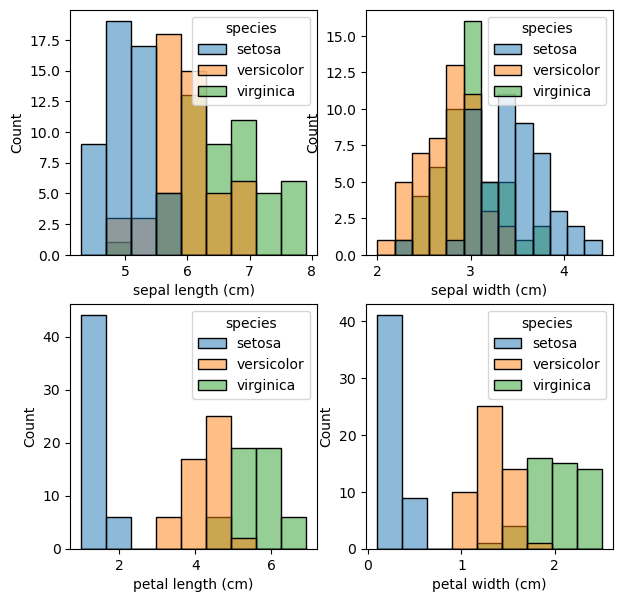

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=df_iris, x='sepal length (cm)', hue='species', ax=axs[0, 0])
sns.histplot(data=df_iris, x='sepal width (cm)', hue='species', ax=axs[0, 1])
sns.histplot(data=df_iris, x='petal length (cm)', hue='species', ax=axs[1, 0])
sns.histplot(data=df_iris, x='petal width (cm)', hue='species', ax=axs[1, 1])

plt.show()

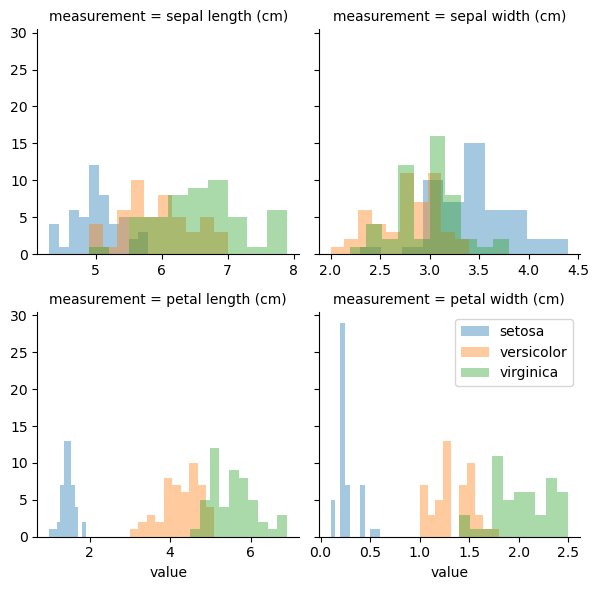

In [12]:
# Plot alternativo
iris_long = pd.melt(df_iris, "species", var_name="measurement")
g = sns.FacetGrid(iris_long, hue="species", col="measurement", col_wrap=2, sharex=False)
g.map(plt.hist, "value", alpha=.4)
plt.legend()
plt.show()

## Estandarización de los datos

Antes de aplicar el Análisis de Componentes Principales (PCA), es fundamental **escalar las variables numéricas** para que todas contribuyan de manera equitativa al análisis.  El PCA se basa en la **varianza** y en la **covarianza** entre las variables; por tanto, si una variable tiene una escala mucho mayor que las demás, dominará las primeras componentes principales.

La estandarización transforma los datos de manera que cada variable tenga:

- **Media ($\mu$) = 0**  
- **Desviación estándar ($\sigma$) = 1**

El proceso se realiza aplicando la siguiente transformación a cada variable:

\begin{equation}
z = \frac{x - \bar{x}}{s}
\end{equation}

donde:
- $x$ es el valor original,  
- $\bar{x}$ es la media de la variable,  
- $s$ es su desviación estándar.

De este modo, todas las variables quedan en una escala comparable, permitiendo que el PCA identifique las direcciones de máxima variabilidad sin verse influenciado por las unidades originales de medida.


In [14]:
# Datos estandarizados

# 1. Instanciamos el escalador elegido
scaler = StandardScaler()

# 2. Aplicamos un fit y un transform a los datos (recordar que son dos operaciones diferentes)
X_std = scaler.fit_transform(X_n)

In [15]:
X_std.shape # 2 dimensiones, 4 variables para 150 registros cada una

(150, 4)

#### Verificar estandarización

In [16]:
display(X_std)

array([[-9.00681170e-01,  1.01900435e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00, -1.31979479e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.38535265e+00,  3.28414053e-01, -1.39706395e+00,
        -1.31544430e+00],
       [-1.50652052e+00,  9.82172869e-02, -1.28338910e+00,
        -1.31544430e+00],
       [-1.02184904e+00,  1.24920112e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-5.37177559e-01,  1.93979142e+00, -1.16971425e+00,
        -1.05217993e+00],
       [-1.50652052e+00,  7.88807586e-01, -1.34022653e+00,
        -1.18381211e+00],
       [-1.02184904e+00,  7.88807586e-01, -1.28338910e+00,
        -1.31544430e+00],
       [-1.74885626e+00, -3.62176246e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00,  9.82172869e-02, -1.28338910e+00,
        -1.44707648e+00],
       [-5.37177559e-01,  1.47939788e+00, -1.28338910e+00,
        -1.31544430e+00],
       [-1.26418478e+00,  7.88807586e-01, -1.22655167e+00,
      

### Valores y vectores propios de la matriz de covarianza (a mano)

Las **entradas** de la matriz de covarianza se pueden expresar de la siguiente forma:

\begin{equation}
\sigma_{jk} = \frac{1}{n - 1} \sum_{i=1}^{n} (x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k)
\end{equation}

Cada elemento $\sigma_{jk}$ representa la **covarianza** entre las variables $j$ y $k$.  La diagonal principal contiene las **varianzas** de cada variable, mientras que las entradas fuera de la diagonal indican el grado de **correlación lineal** entre pares de variables.

Agrupando todas estas entradas, la **matriz de covarianza** $\Sigma$ se puede escribir en forma matricial como:

\begin{equation}
\Sigma = \frac{1}{n - 1} 
\left( (\mathbf{X} - \bar{\mathbf{X}})^{\mathrm{T}} (\mathbf{X} - \bar{\mathbf{X}}) \right)
=
\begin{pmatrix}
\sigma_{11} & \sigma_{12} & \ldots & \sigma_{1m} \\
\sigma_{21} & \sigma_{22} & \ldots & \sigma_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{m1} & \sigma_{m2} & \ldots & \sigma_{mm}
\end{pmatrix}
\end{equation}

donde:

- $\mathbf{X}$ es la matriz de datos con $n$ observaciones y $m$ variables,  
- $\bar{\mathbf{X}}$ es una matriz donde cada columna contiene la media correspondiente a una variable (repetida en todas las filas).

In [18]:
# Definimos el vector de medias \bar{x}
mean_vect = np.mean(X_std, axis=0) # la media se hace por las "filas" del array X_std, que son las columnas de variables
mean_vect

array([-1.69031455e-15, -1.84297022e-15, -1.69864123e-15, -1.40924309e-15])

In [19]:
# Creamos la matriz de covarianza y cada una de sus entradas
# Utilizamos la segunda expresion, para \Sigma
cov_matrix = (X_std - mean_vect).T.dot(X_std - mean_vect) / (X_std.shape[0]-1)
cov_matrix

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

In [20]:
# O también simplemente utilizamos un método cov de numpy
cov_matrix = np.cov(X_std.T)
cov_matrix

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

La diagonal son las varianzas por variable.

El siguiente paso consiste en calcular los **valores propios** (*eigenvalues*) y **vectores propios** (*eigenvectors*) de $\Sigma$. Los valores propios indican cuánta varianza explica cada componente principal, mientras que los vectores propios determinan las **direcciones** (o ejes) de máxima varianza en el espacio original de los datos.


In [21]:
# numpy puede calcular estos valores y vectores propios
eigen_values, eigen_vectors =  np.linalg.eig(cov_matrix)
print("Eigenvalores \n%s"%eigen_values)
print("Eigenvectores \n%s"%eigen_vectors)

Eigenvalores 
[2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectores 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


Una forma alternativa es utilizar la matriz de **correlaciones** en lugar de la de **covarianza** para encontrar estos valores y vectores propios, aunque es equivalente a lo que hicimos, puesto que la correlación sería como una covarianza normalizada.

In [22]:
corr_matrix = np.corrcoef(X_std.T)
corr_matrix

array([[ 1.        , -0.11756978,  0.87175378,  0.81794113],
       [-0.11756978,  1.        , -0.4284401 , -0.36612593],
       [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543],
       [ 0.81794113, -0.36612593,  0.96286543,  1.        ]])

In [23]:
eig_val, eig_vec =  np.linalg.eig(corr_matrix)
print("Eigenvalores \n%s"%eig_val)
print("Eigenvectores \n%s"%eig_vec)

Eigenvalores 
[2.91849782 0.91403047 0.14675688 0.02071484]
Eigenvectores 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


## Selección de componentes principales

El objetivo del **Análisis de Componentes Principales (PCA)** es **reducir la dimensionalidad** del espacio vectorial original, proyectando los datos en un nuevo espacio de menor dimensión definido por las direcciones de **mayor varianza**.  Estas direcciones corresponden a los **vectores propios** de la matriz de covarianza, que señalan los ejes a lo largo de los cuales los datos varían más.

Como estos vectores propios son mutuamente **ortogonales**, forman un sistema de ejes perpendiculares entre sí. Para que constituyan una **base ortonormal**, se normalizan de manera que su **magnitud sea igual a 1**, es decir:

\begin{equation}
\|\mathbf{v}_j\| = 1 \quad \text{para todo } j = 1, 2, \ldots, m
\end{equation}

Una vez calculados los valores propios ($\lambda_j$) y vectores propios $(\mathbf{v}_j)$, se ordenan los componentes de acuerdo con la magnitud de los valores propios, de mayor a menor. Los **primeros componentes principales** corresponden a los vectores propios asociados a los valores propios más grandes, ya que son los que explican la mayor proporción de la **varianza total** del conjunto de datos.

En la práctica, se selecciona un número reducido de componentes $k < m$ que capture un porcentaje suficientemente alto de la varianza total (por ejemplo, el 90 % o 95 %).

In [25]:
# Checamos que la longitud de los eigenvectores sea 1
for element in eigen_vectors:
    print(np.linalg.norm(element))

0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999999


Los vectores propios que tengan el valor propio con menos información de los datos serán los que no tomaremos en cuenta. Hacemos un ranking.

In [26]:
# juntamos eigenvalores y eigenvectores en una sola lista
eigen_pairs = [(np.abs(eigen_values[i]),eigen_vectors[:,i]) for i in range(len(eigen_values))]
eigen_pairs
# tendría que haber un np.sort para ordenar de mayor a menor.

[(np.float64(2.9380850501999936),
  array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654])),
 (np.float64(0.9201649041624856),
  array([-0.37741762, -0.92329566, -0.02449161, -0.06694199])),
 (np.float64(0.14774182104494743),
  array([-0.71956635,  0.24438178,  0.14212637,  0.63427274])),
 (np.float64(0.020853862176462627),
  array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))]

In [27]:
#ordenar eigenvectores
eigen_pairs.sort()
eigen_pairs.reverse()
eigen_pairs

[(np.float64(2.9380850501999936),
  array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654])),
 (np.float64(0.9201649041624856),
  array([-0.37741762, -0.92329566, -0.02449161, -0.06694199])),
 (np.float64(0.14774182104494743),
  array([-0.71956635,  0.24438178,  0.14212637,  0.63427274])),
 (np.float64(0.020853862176462627),
  array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))]

In [28]:
print('Eigenvalores en orden descendente')
for ep in eigen_pairs:
    print(ep[0])

Eigenvalores en orden descendente
2.9380850501999936
0.9201649041624856
0.14774182104494743
0.020853862176462627


El eigenvalor está en este caso, está relacionado con la varianza que la componente suele llevar. Poniendo cuánto porcentaje de la varianza se lleva cada componente,

In [29]:
total = eigen_values.sum()
var_c = [(i/total)*100 for i in sorted(eigen_values, reverse=True)]
var_c

[np.float64(72.96244541329992),
 np.float64(22.85076178670175),
 np.float64(3.668921889282865),
 np.float64(0.5178709107154891)]

Vemos que la primera componente se lleva más del 70% de la variabilidad, mientras que la última menos de 1%.

In [30]:
# o también haciendolo como frecuencia acumulada
np.cumsum(var_c)

array([ 72.96244541,  95.8132072 ,  99.48212909, 100.        ])

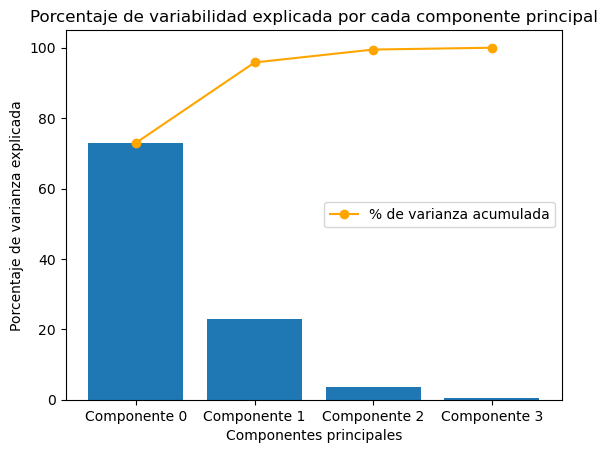

In [32]:
# Gráfico para la varianza por componente

component_list = []
for i in range(len(eigen_values)):
    component_list.append('Componente '+str(i))

fig = plt.figure()

ax = fig.add_subplot()

ax.bar(x=component_list,height=var_c)
ax.plot(component_list,np.cumsum(var_c),'o-',color='orange', label='% de varianza acumulada')

ax.set_ylabel('Porcentaje de varianza explicada')
ax.set_xlabel('Componentes principales')
ax.set_title('Porcentaje de variabilidad explicada por cada componente principal')

plt.legend(loc = 'center right')

plt.show()

### Matriz de proyección

Concatenar lo vectores propios que se quieren conservar, con el objetivo de reducir de un espacio vectorial de dimensión $m$ a uno de menor dimensión.

En este caso hacemos una elección de dos componentes principales.

In [33]:
#np.hstack se encarga de juntar vectores de forma columnar,

W = np.hstack((eigen_pairs[0][1].reshape(4,1),
               eigen_pairs[1][1].reshape(4,1)))
W

array([[ 0.52106591, -0.37741762],
       [-0.26934744, -0.92329566],
       [ 0.5804131 , -0.02449161],
       [ 0.56485654, -0.06694199]])

In [34]:
# primera fila de datos (antes)
X_n[0]

array([5.1, 3.5, 1.4, 0.2])

Checando dimensiones, la transformación va de la siguiente manera,

\begin{equation}
\mathbf{Y} = \mathbf{X} \cdot \mathbf{W}
\end{equation}

donde $\mathbf{X}$ es $150 \times 4$, $\mathbf{W}$ sería $4 \times 2$, y por lo tanto, $\mathbf{Y}$ resultaría de $150 \times 2$.

#### Transformación de datos

In [35]:
Y = X_std.dot(W)
Y

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356],
       [-2.1663101 , -1.04369065],
       [-2.32613087, -0.13307834],
       [-2.2184509 ,  0.72867617],
       [-2.6331007 ,  0.96150673],
       [-2.1987406 , -1.86005711],
       [-2.26221453, -2.68628449],
       [-2.2075877 , -1.48360936],
       [-2.19034951, -0.48883832],
       [-1.898572  , -1.40501879],
       [-2.34336905, -1.12784938],
       [-1.914323  , -0.40885571],
       [-2.20701284, -0.92412143],
       [-2.7743447 , -0.45834367],
       [-1.81866953, -0.08555853],
       [-2.22716331, -0.13725446],
       [-1.95184633,  0.62561859],
       [-2.05115137, -0.24216355],
       [-2.16857717, -0.52714953],
       [-2.13956345,

In [36]:
Y.shape

(150, 2)

In [37]:
# Puedo hacer un nuevo dataframe
data_iris_pca = pd.DataFrame(
{
    'Component_1': Y[:,0],
    'Component_2': Y[:,1],
    'Species': X_c
})
data_iris_pca.head(5)

,Component_1,Component_2,Species
0,-2.264703,-0.480027,setosa
1,-2.080961,0.674134,setosa
2,-2.364229,0.341908,setosa
3,-2.299384,0.597395,setosa
4,-2.389842,-0.646835,setosa


## Proyección de los datos sobre el subespacio de componentes principales

Una vez seleccionados los **dos primeros componentes principales** del conjunto de datos *Iris*, podemos proyectar las observaciones originales sobre el **subespacio vectorial** definido por estos dos vectores propios.

El objetivo de esta proyección es **representar los datos en un espacio de menor dimensión** (en este caso, bidimensional), conservando la mayor parte posible de la **varianza total**.  

En este caso, $k = 2$, por lo que el resultado será una representación bidimensional que captura la mayor parte de la variabilidad de las medidas originales de sépalos y pétalos. Esta proyección permitirá **visualizar gráficamente** cómo se distribuyen las tres especies de *Iris* en el nuevo espacio definido por los dos primeros componentes principales.


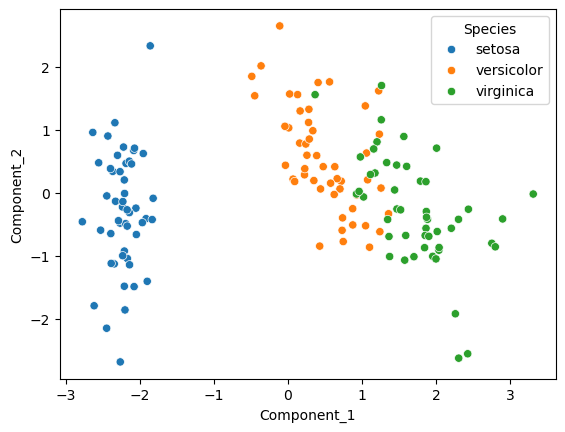

In [39]:
# proyección en el subespacio vectorial resultante
sns.scatterplot(data=data_iris_pca,
                x='Component_1',
                y='Component_2',
                hue='Species')
plt.show()

## PCA con *scikit-learn*

Hasta ahora hemos implementado el Análisis de Componentes Principales (PCA) paso a paso utilizando únicamente operaciones básicas de álgebra lineal con **NumPy**, con el fin de comprender su fundamento matemático.  En esta sección aplicaremos el mismo procedimiento, pero utilizando la clase `PCA` de la librería **scikit-learn**, que automatiza el cálculo de la descomposición y la proyección de los datos.

El módulo `sklearn.decomposition` proporciona una implementación eficiente de PCA que realiza internamente los siguientes pasos:

1. Centrar los datos (restar la media de cada variable).  
2. Calcular la descomposición en valores y vectores propios de la matriz de covarianza o, más comúnmente, aplicar una descomposición en valores singulares (SVD).  
3. Ordenar las componentes principales según la varianza explicada.  
4. Proyectar los datos sobre las nuevas componentes.

La transformación general puede escribirse como:

\begin{equation}
\mathbf{Z} = \mathbf{X}_{\text{est}} \, \mathbf{V}_k
\end{equation}

donde:
- $\mathbf{X}_{\text{est}}$ es la matriz de datos estandarizados,
- $\mathbf{V}_k$ contiene los vectores propios asociados a las $k$ mayores varianzas.

A diferencia del enfoque “a mano”, `scikit-learn` ofrece además información adicional, como:
- La **varianza explicada** por cada componente (`explained_variance_ratio_`),  
- Las **cargas de los componentes** (`components_`),  
- Y una interfaz directa para transformar y visualizar los datos.

En el siguiente bloque de código aplicaremos PCA sobre el conjunto de datos *Iris*, seleccionando las dos primeras componentes principales, y compararemos los resultados con el método manual.


In [50]:
# Importación de datos
iris = load_iris()

df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target
df_iris['species'] = df_iris['species'].map(dict(zip(range(3), iris.target_names)))

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [51]:
# Como sólo aplicamos PCA a variables numéricas, ponemos estas por separado
X_n = df_iris.iloc[:,0:4].values # columna 0,1,2,3
X_c = df_iris.iloc[:,4].values # columna 4 

# Estandarizamos los valores numéricos
scaler = StandardScaler()
X_std = scaler.fit_transform(X_n)

Lo que hay que indicarle a la función es el número de componentes requeridas.

In [52]:
pca = PCA(n_components=2)

# Creamos las nuevas variables de la misma manera
Y = pca.fit_transform(X_std)

Y

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538],
       [-2.07563095,  1.48917752],
       [-2.44402884,  0.0476442 ],
       [-2.23284716,  0.22314807],
       [-2.33464048, -1.11532768],
       [-2.18432817, -0.46901356],
       [-2.1663101 ,  1.04369065],
       [-2.32613087,  0.13307834],
       [-2.2184509 , -0.72867617],
       [-2.6331007 , -0.96150673],
       [-2.1987406 ,  1.86005711],
       [-2.26221453,  2.68628449],
       [-2.2075877 ,  1.48360936],
       [-2.19034951,  0.48883832],
       [-1.898572  ,  1.40501879],
       [-2.34336905,  1.12784938],
       [-1.914323  ,  0.40885571],
       [-2.20701284,  0.92412143],
       [-2.7743447 ,  0.45834367],
       [-1.81866953,  0.08555853],
       [-2.22716331,  0.13725446],
       [-1.95184633, -0.62561859],
       [-2.05115137,  0.24216355],
       [-2.16857717,  0.52714953],
       [-2.13956345,

In [53]:
# Hago el nuevo dataframe
df_iris_pca = pd.DataFrame(
{
    'Component_1': Y[:,0],
    'Component_2': Y[:,1],
    'Species': df_iris['species']
})
df_iris_pca.head(5)

,Component_1,Component_2,Species
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa


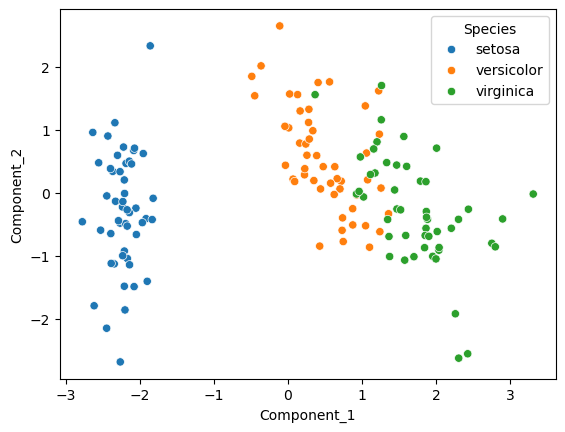

In [54]:
# proyección en el subespacio vectorial resultante
sns.scatterplot(data=data_iris_pca,
                x='Component_1',
                y='Component_2',
                hue='Species')
plt.show()

In [55]:
# varianza explicada
pca.explained_variance_ratio_

array([0.72962445, 0.22850762])

In [56]:
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199]])

## Resumen y conclusiones

En este notebook realizamos un recorrido completo por el **Análisis de Componentes Principales (PCA)** utilizando el conjunto de datos clásico *Iris*.  
El objetivo fue comprender tanto los fundamentos matemáticos del método como su implementación práctica.

Primero, revisamos los **conceptos teóricos** detrás del PCA:
- La necesidad de **estandarizar los datos** antes del análisis para que todas las variables contribuyan de manera equilibrada.  
- La construcción de la **matriz de covarianza** como representación de las relaciones lineales entre las variables.  
- La obtención de **valores propios** y **vectores propios**, los cuales definen las direcciones de máxima varianza en los datos.  
- La **selección y proyección** de los datos sobre los primeros componentes principales para reducir dimensionalidad manteniendo la mayor parte de la información.

Posteriormente, implementamos el procedimiento **paso a paso con NumPy**, lo que permitió visualizar cada etapa del cálculo: desde la estandarización hasta la proyección en el subespacio bidimensional.  
Después, comparamos los resultados con la implementación de `PCA` en **scikit-learn**, confirmando que los componentes obtenidos y la varianza explicada son equivalentes.

### Conclusiones

- El PCA es una herramienta fundamental para **explorar y visualizar datos multivariados**, permitiendo reducir la complejidad del conjunto original sin perder información esencial.  
- Los **vectores propios** indican las direcciones principales de variabilidad, mientras que los **valores propios** cuantifican la importancia relativa de cada componente.  
- En el caso del dataset *Iris*, las **dos primeras componentes** capturan la mayor parte de la varianza, lo que hace posible representar los datos en un plano bidimensional donde las especies se diferencian de forma clara.  
- Aunque es posible implementar PCA manualmente, el uso de librerías como **scikit-learn** facilita el análisis y garantiza eficiencia, manteniendo la posibilidad de acceder a resultados interpretables (varianza explicada, cargas, proyecciones, etc.).

En resumen, el PCA no solo reduce la dimensionalidad, sino que también proporciona una **nueva perspectiva sobre la estructura interna de los datos**, ayudando a descubrir patrones y relaciones que no son evidentes en el espacio original.
